In [18]:
@time using CSV                          # CSVファイルの操作のためのパッケージ
@time using DataFrames                   # データフレーム
@time using Distributions                # 確率分布
@time using NLsolve                      # 非線形方程式の近似根を求める
@time using Plots                        # グラフ描画
@time using Parameters                   # 数値モデルのパラメーターを処理するために使用するパッケージ
@time using QuadGK                       # 1次元の数値積分
@time using SpecialFunctions             # 特殊関数
@time using StatsBase                    # 統計にかかわる基本的な関数群が提供されているパッケージ

  0.000063 seconds (108 allocations: 9.469 KiB)
  0.000038 seconds (108 allocations: 9.469 KiB)
  0.000026 seconds (108 allocations: 9.469 KiB)
  0.000035 seconds (108 allocations: 9.469 KiB)
  0.000029 seconds (108 allocations: 9.469 KiB)
  0.000029 seconds (108 allocations: 9.469 KiB)
  0.000029 seconds (108 allocations: 9.469 KiB)
  0.000024 seconds (108 allocations: 9.484 KiB)
  0.000029 seconds (108 allocations: 9.469 KiB)


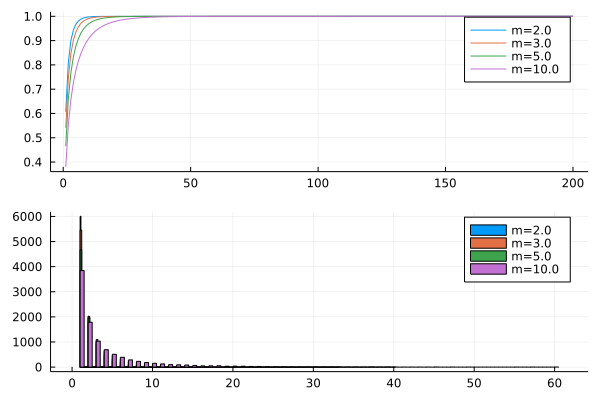

In [19]:
# 確率質量関数 ( PMF : probability mass function )
ρ(ω,m) = ω^m/(m*log(ω+1)*(ω+1)^m)

# 累積分布関数 ( CDF : cumulative distribution function )
function ζ(ω,M=200)
    x = zeros(M)
    cdf = 0.0
    for m in 1:M
        cdf += ρ(ω,m) 
        x[m] = cdf
    end
    return x
end

# イベントサイズ m
@inline function ξ(ω,x,M=200)
    y = rand(Uniform(0,1))
    if x[M] <= y[1] 
        m = M
    else
        for i in 1:M-1
            if x[i] >= y[1]
                m = i
                break
            else
                continue
            end
        end
    end
    return m
end;

#Plot
x1 = [ξ(2.0,ζ(2.0)) for i in 1:10000]
x2 = [ξ(3.0,ζ(3.0)) for i in 1:10000]
x3 = [ξ(5.0,ζ(5.0)) for i in 1:10000]
x4 = [ξ(10.0,ζ(10.0)) for i in 1:10000]

plt  = (plot(ζ(2.0),label="m=2.0") ; plot!(ζ(3.0),label="m=3.0") ; plot!(ζ(5.0),label="m=5.0") ; plot!(ζ(10.0),label="m=10.0"))
hist = histogram(x1,label="m=2.0") ; histogram!(x2,label="m=3.0") ; histogram!(x3,label="m=5.0") ; histogram!(x4,label="m=10.0")

plot(plt,hist,layout=(2,1))

In [20]:
# イベントサイズの分布
import Distributions: quantile, minimum, maximum, pdf, cdf

mutable struct Myprob{T <: Real} <: DiscreteUnivariateDistribution
    ω::T
end
ω = 0.01
prob = Myprob(ω)

quantile(prob::Myprob,m) = prob.ω^m/(m*log(prob.ω+1)*(prob.ω+1)^m)

quantile(prob,1) # イベントサイズが"1"の場合の分位点(GPT3.5)

0.9950412951201034

In [21]:
# 非線形方程式 ( Non-linear equations )
@inline fun(t,λ0,λ,τ,ω,K,Δ) = λ0*t+sum([λ[i,1]*τ[i]*(1-exp(-t/τ[i])) for i in 1:K])-Δ*ω/log(ω+1)

# 解の導出 Find solutions to non-linear equations
@inline function nls(func, params...; ini = [0.0]) 
    if typeof(ini) <: Number
        r = nlsolve((vout,vin)->vout[1]=func(vin[1],params...), [ini])
        v = r.zero[1]
    else
        r = nlsolve((vout,vin)->vout .= func(vin,params...), ini)
        v = r.zero
    end
    return v, r.f_converged
end

nls(fun,0.01,0.99,1.0,2.0,1,rand(Exponential(1)),ini=0.0) # (近似根, true : 近似根 f=0 を満たす) 

(1.6379221336325271, true)

In [22]:
# Jump in [t,t+dt]
@inline jump(t,λ,τ,n,m) = λ*exp(-t/τ)+n*m/τ

# No jump during [t,t+dt]
@inline no_jump(λ,τ,t) = λ*exp(-t/τ)

# イベント時刻 (T,N) = (10^8,10^8) @time : 13.038416 seconds (2 allocations: 762.939 MiB, 0.72% gc time)
function time(T,N)
    t = rand(Uniform(0.0,T),N)
    sort!(t) # 昇順に並び替える
    return t
end;

# 手法 : 時間伸縮理論 ( Time-rescaling theorem )
function Time_Rescaling_Theorem(par,T=10^4,N=10^4) # (T,N) = (実時間,データ数)
    @unpack K,λ0,ω,n = par
    
    # 空の配列
    λt = zeros(N) # N = 10^8 @time 0.426187 seconds
    λ  = zeros(K,2)
    tΔ = zeros(2)
    
    # イベント発生時刻
    t = time(T,N)
    
    # 時間減衰項 τ 
    τ = rand(Uniform(1.0,3.0),K) #連続型
    #   rand(DiscreteUniform(min=1,max=3),K) #離散型
    
    # 分岐比 n 
    n = [n/K for i in 1:K]
    
    # 累積分布関数
    CDF = ζ(ω)
    
    # 解 (イベント発生時刻) の導出 
    Δ = nls(fun,λ0,λ[:,1],τ,ω,K,rand(Exponential(1)),ini=0.0)[1] # x[:,1] : 1列目を取る
    tΔ[2] = tΔ[1] + Δ
    m = ξ(ω,CDF)
    λ[:,2] = [jump(Δ,λ[i,1],τ[i],n[i],m) for i in 1:K]
    for i in 1:N
        while true
            if t[i] < tΔ[2]
                δ = t[i] - tΔ[1]
                λt[i] = λ0+sum([no_jump(λ[i,1],τ[i],δ) for i in 1:K])
                break
            else
                tΔ[1] = tΔ[2]
                λ[:,1] = λ[:,2]
                Δ = nls(fun,λ0,λ[:,1],τ,ω,K,rand(Exponential(1)),ini=0.0)[1]
                tΔ[2] = tΔ[1] + Δ
                m = ξ(ω,CDF)
                λ[:,2] = [jump(Δ,λ[i,1],τ[i],n[i],m) for i in 1:K]
            end
        end
    end
    t,τ,n,λt
end

# パラメータ
par = (
    K  = 1, # メモリーカーネル関数( 指数関数 )の数
    n  = 0.99, # 分岐比
    ω  = 0.01,
    λ0 = 0.01
)

@time t,τ,n,λt = Time_Rescaling_Theorem(par)
println("・分岐比 　n = $n")
println("・時間減衰 τ = $τ")

# データフレーム
df = DataFrame(Time=t,Intensity=λt) 
@show describe(df.Intensity)

# CSV
#CSV.write("/home/aaa/bbb/data_name.csv",df)

# Plot
plt = plot(df.Time,df.Intensity,xlabel = "Time",ylabel = "Intensity",title  = "Hawkes process",label  = "")
hist = histogram(df.Intensity,xlabel = "Intensity",ylabel = "Counts",title = "Frequency distribution",label = "")
plot(plot!(plt,x->mean(df.Intensity),label="Mean value",legendfontsize=5),hist,layout=(2,1))

  0.462268 seconds (2.01 M allocations: 109.016 MiB, 5.54% gc time, 89.50% compilation time)
・分岐比 　n = [0.99]
・時間減衰 τ = [2.270555956875915]
Summary Stats:
Length:         10000
Missing Count:  0
Mean:           0.871223
Minimum:        0.010000
1st Quartile:   0.010000
Median:         0.010000
3rd Quartile:   0.010756
Maximum:        54.096401
Type:           Float64
describe(df.Intensity) = nothing


  0.318920 seconds (2.04 M allocations: 112.271 MiB, 3.69% gc time, 75.12% compilation time)
・分岐比 　n = [0.99]
・時間減衰 τ = [1.0716519238425375]
Summary Stats:
Length:         10000
Missing Count:  0
Mean:           1.845542
Minimum:        0.010000
1st Quartile:   0.010000
Median:         0.010000
3rd Quartile:   0.010000
Maximum:        89.467056
Type:           Float64
describe(df.Intensity) = nothing


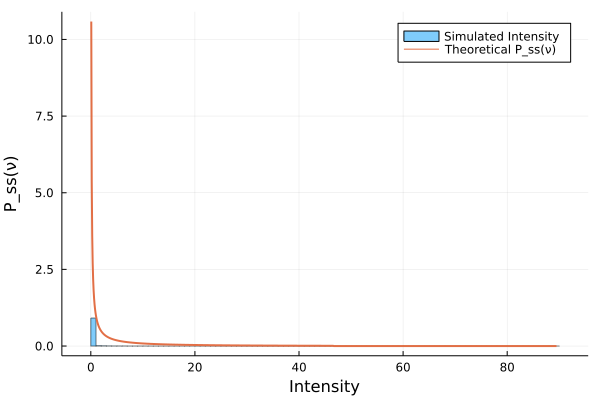

In [23]:
using Statistics # 平均を計算するため
using Plots # プロットするため
using Distributions # 分布関数を使用

# Jump in [t,t+dt]
@inline jump(t,λ,τ,n,m) = λ*exp(-t/τ)+n*m/τ

# No jump during [t,t+dt]
@inline no_jump(λ,τ,t) = λ*exp(-t/τ)

# イベント時刻 (T,N) = (10^8,10^8) @time : 13.038416 seconds (2 allocations: 762.939 MiB, 0.72% gc time)
function time(T,N)
    t = rand(Uniform(0.0,T),N)
    sort!(t) # 昇順に並び替える
    return t
end;

# 手法 : 時間伸縮理論 ( Time-rescaling theorem )
function Time_Rescaling_Theorem(par,T=10^4,N=10^4) # (T,N) = (実時間,データ数)
    @unpack K,λ0,ω,n = par
    
    # 空の配列
    λt = zeros(N) # N = 10^8 @time 0.426187 seconds
    λ  = zeros(K,2)
    tΔ = zeros(2)
    
    # イベント発生時刻
    t = time(T,N)
    
    # 時間減衰項 τ 
    τ = rand(Uniform(1.0,3.0),K) #連続型
    #   rand(DiscreteUniform(min=1,max=3),K) #離散型
    
    # 分岐比 n 
    n = [n/K for i in 1:K]
    
    # 累積分布関数
    CDF = ζ(ω)
    
    # 解 (イベント発生時刻) の導出 
    Δ = nls(fun,λ0,λ[:,1],τ,ω,K,rand(Exponential(1)),ini=0.0)[1] # x[:,1] : 1列目を取る
    tΔ[2] = tΔ[1] + Δ
    m = ξ(ω,CDF)
    λ[:,2] = [jump(Δ,λ[i,1],τ[i],n[i],m) for i in 1:K]
    for i in 1:N
        while true
            if t[i] < tΔ[2]
                δ = t[i] - tΔ[1]
                λt[i] = λ0+sum([no_jump(λ[i,1],τ[i],δ) for i in 1:K])
                break
            else
                tΔ[1] = tΔ[2]
                λ[:,1] = λ[:,2]
                Δ = nls(fun,λ0,λ[:,1],τ,ω,K,rand(Exponential(1)),ini=0.0)[1]
                tΔ[2] = tΔ[1] + Δ
                m = ξ(ω,CDF)
                λ[:,2] = [jump(Δ,λ[i,1],τ[i],n[i],m) for i in 1:K]
            end
        end
    end
    t,τ,n,λt
end

# P_ss(ν)の計算関数
function calculate_P_ss(ν_vals, ν_0, τ, n)
    ν_cut = 1 / (2τ * (1 - n))
    P_ss_vals = ν_vals .^ (-1 + 2*ν_0*τ) .* exp.(-2*τ*(1-n).*ν_vals)
    P_ss_vals[ν_vals .> ν_cut] .= 0
    return P_ss_vals
end

# ヒストグラムのプロット関数
function plot_intensity_distribution(λt, ν_0, τ, n)
    # 強度のヒストグラムをプロット
    histogram(λt, bins=100, normed=true, label="Simulated Intensity", alpha=0.5, xlabel="Intensity", ylabel="P_ss(ν)")

    # P_ss(ν)の計算とプロット
    ν_vals = range(0, stop=maximum(λt), length=1000)
    P_ss_vals = calculate_P_ss(ν_vals, ν_0, τ, n)
    plot!(ν_vals, P_ss_vals, label="Theoretical P_ss(ν)", linewidth=2, legend=:topright)
end

# パラメータ
par = (
    K  = 1, # メモリーカーネル関数( 指数関数 )の数
    n  = 0.99, # 分岐比
    ω  = 0.01,
    λ0 = 0.01
)

@time t,τ,n,λt = Time_Rescaling_Theorem(par)

println("・分岐比 　n = $n")
println("・時間減衰 τ = $τ")

# データフレーム
df = DataFrame(Time=t,Intensity=λt) 
@show describe(df.Intensity)

# CSV
#CSV.write("/home/aaa/bbb/data_name.csv",df)



# パラメータの設定
ν_0 = par.λ0
τ_avg = mean(τ) # τの平均値を使用
n = par.n

# Plot
plt = plot(df.Time,df.Intensity,xlabel = "Time",ylabel = "Intensity",title  = "Hawkes process",label  = "")
hist = histogram(df.Intensity,xlabel = "Intensity",ylabel = "Counts",title = "Frequency distribution",label = "")
plot(plot!(plt,x->mean(df.Intensity),label="Mean value",legendfontsize=5),hist,layout=(2,1))

# 強度分布のプロット
plot_intensity_distribution(λt, ν_0, τ_avg, n)

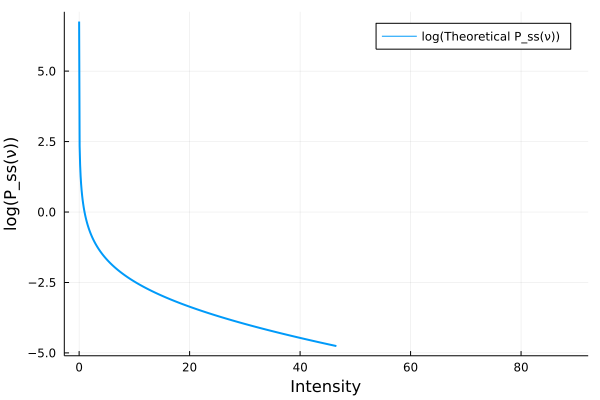

In [24]:
# ヒストグラムとlog P_ss(ν)のプロット関数
function plot_intensity_distribution_with_log(λt, ν_0, τ, n)
    # 強度のヒストグラムをプロット
    histogram(λt, bins=100, normed=true, label="Simulated Intensity", alpha=0.5, xlabel="Intensity", ylabel="P_ss(ν)")

    # P_ss(ν)の計算
    ν_vals = range(0.001, stop=maximum(λt), length=1000) # 0を避けるために範囲を調整
    P_ss_vals = calculate_P_ss(ν_vals, ν_0, τ, n)
    
    # P_ss(ν)のプロット
    plot!(ν_vals, P_ss_vals, label="Theoretical P_ss(ν)", linewidth=2, legend=:topright)

    # log P_ss(ν)のプロット (新しいウィンドウで表示)
    plot(ν_vals, log.(P_ss_vals), label="log(Theoretical P_ss(ν))", linewidth=2, xlabel="Intensity", ylabel="log(P_ss(ν))", legend=:topright)
end

# 強度分布とlog P_ss(ν)のプロット
plot_intensity_distribution_with_log(λt, ν_0, τ_avg, n)


In [25]:
using Plots
using Distributions

# パラメータ設定
ν_0 = 0.01
τ = 1.0
dt = 0.001
T = 10000
time = 0:dt:T
N = length(time)

# 強度ν(t)の計算関数
function compute_intensity(ν_0, n, τ, T, dt)
    z = zeros(T)
    ν = zeros(T)
    for t in 2:T
        z[t] = z[t-1] * exp(-dt/τ) + (rand() < ν[t-1]*dt ? 1 : 0)
        ν[t] = ν_0 + n * z[t] / τ
    end
    return ν
end

# P_{ss}(ν)を計算する関数
function compute_P_ss(ν, ν_0, τ, n)
    ν_cut = 1 / (2 * τ * (1 - n))
    P_ss = ν .^ (-1 + 2 * ν_0 * τ) .* exp.(-2 * τ * (1 - n) .* ν)
    P_ss[ν .> ν_cut] .= 0
    return P_ss / sum(P_ss)
end

# グラフ作成
function plot_distributions(ν_0, τ, n_values, T, dt)
    plot()
    for n in n_values
        ν = compute_intensity(ν_0, n, τ, T, dt)
        P_ss = compute_P_ss(ν, ν_0, τ, n)
        histogram!(ν, label="n=$n", alpha=0.5, normed=true)
    end
    xlabel!("Intensity ν")
    ylabel!("Probability Density P_{ss}(ν)")
    title!("Distribution of Intensity")
end

# nの値に対してグラフを描画
n_values = [0.999, 0.99]
plot_distributions(ν_0, τ, n_values, N, dt)


LoadError: invalid redefinition of constant time